In [ ]:
import numpy as np
import CRISP.trainer as ct
import scanpy as sc
import pandas as pd

In [2]:
sc.set_figure_params(figsize=(5, 5))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [3]:
from sklearn.model_selection import train_test_split
def stratified_downsample(adata, sample_fraction, stratify_key):
    
    stratify_group = adata.obs[stratify_key]
    
    _, sampled_indices = train_test_split(
        np.arange(adata.n_obs),
        stratify=stratify_group,
        test_size=sample_fraction,
        random_state=42
    )
    
    return adata[sampled_indices].copy()

#### overall prediction

In [14]:
# load model trained from all six cell types of NeurIPS dataset, scGPT-human as pre-encoder
exp = ct.Trainer()
model_path = 'model_weights/nips_split_all_model.pt'
exp.load_model(model_path)

nips = sc.read('nips_pp_scFM_resplit.h5ad')
drug_to_smiles = dict(zip(nips.obs['condition'],nips.obs['SMILES']))
smile_df = pd.read_parquet('/data/drug_embeddings/embeddings_lincs_gbm_sci_nips.parquet')

In [7]:
pc9 = sc.read('pc9_hvg_filter_scFM_gse160244.h5ad')

In [15]:
drug = 'Crizotinib'
smiles = drug_to_smiles[drug]
dose = 0.1/14.1

In [16]:
pc9_ctrl = pc9[pc9.obs['drug']=='CTRL'].copy()
pc9_pred, pc9_lat, _ = exp.get_prediction(pc9_ctrl,dose=dose,smile=smiles,smile_df=smile_df,FM_emb='X_scGPT_human')

In [11]:
sci = sc.read('sciplex_pp_hvgenes_scFM_resplit.h5ad')

In [17]:
sci_ctrl = sci[sci.obs['control']==1].copy()
sci_ctrl = stratified_downsample(sci_ctrl,0.4,'cell_type')
sci_ctrl.obsm['X_scGPT_human'] = sci_ctrl.obsm['X_scGPT_human'].astype('float32')
sci_pred, sci_lat, _ = exp.get_prediction(sci_ctrl,dose=dose,smile=smiles,smile_df=smile_df,FM_emb='X_scGPT_human')

In [18]:
nips_ctrl = nips[nips.obs['neg_control']==1].copy()
nips_ctrl = stratified_downsample(nips_ctrl,0.5,'cell_type')
nips_pred, nips_lat, _ = exp.get_prediction(nips_ctrl,dose=dose,smile=smiles,smile_df=smile_df,FM_emb='X_scGPT_human')

In [19]:
bench = sc.read('pbmc_bench_pp_all.h5ad')

In [20]:
bench_ctrl = stratified_downsample(bench,0.5,'cov_method')
bench_pred, bench_lat, _ = exp.get_prediction(bench_ctrl,dose=dose,smile=smiles,smile_df=smile_df,FM_emb='X_scGPT_human')

In [21]:
del nips_pred.obs
nips_pred.obs['cell_type'] = nips_lat.obs['cell_type'].copy()
del sci_pred.obs 
sci_pred.obs['cell_type'] = sci_lat.obs['cell_type'].copy()
del pc9_pred.obs 
pc9_pred.obs['cell_type'] = 'NSCLC'
del bench_pred.obs 
bench_pred.obs['cell_type'] = bench_lat.obs['cell_type'].copy()

In [22]:
all_pred = sc.concat([nips_pred,sci_pred,pc9_pred,bench_pred])

In [23]:
replace_dict = {'cancer_cell':'other cancer cell lines','A549':'lung adenocarcinoma','MCF7':'breast adenocarcinoma','K562':'CML'
                ,'B cell':'B cells','Natural killer cell':'NK cells','CD4+ T cell':'T cells CD4+'}
all_pred.obs['cell_type'] = all_pred.obs['cell_type'].apply(lambda x: replace_dict[x] if x in replace_dict else x)

In [24]:
cancer = ['other cancer cell lines','breast adenocarcinoma','lung adenocarcinoma','CML','NSCLC']
all_pred.obs['tissue'] = ['cancer' if i in cancer else 'PBMC' for i in all_pred.obs['cell_type']]

In [ ]:
sc.pp.neighbors(all_pred)
sc.tl.umap(all_pred, min_dist=0.3)

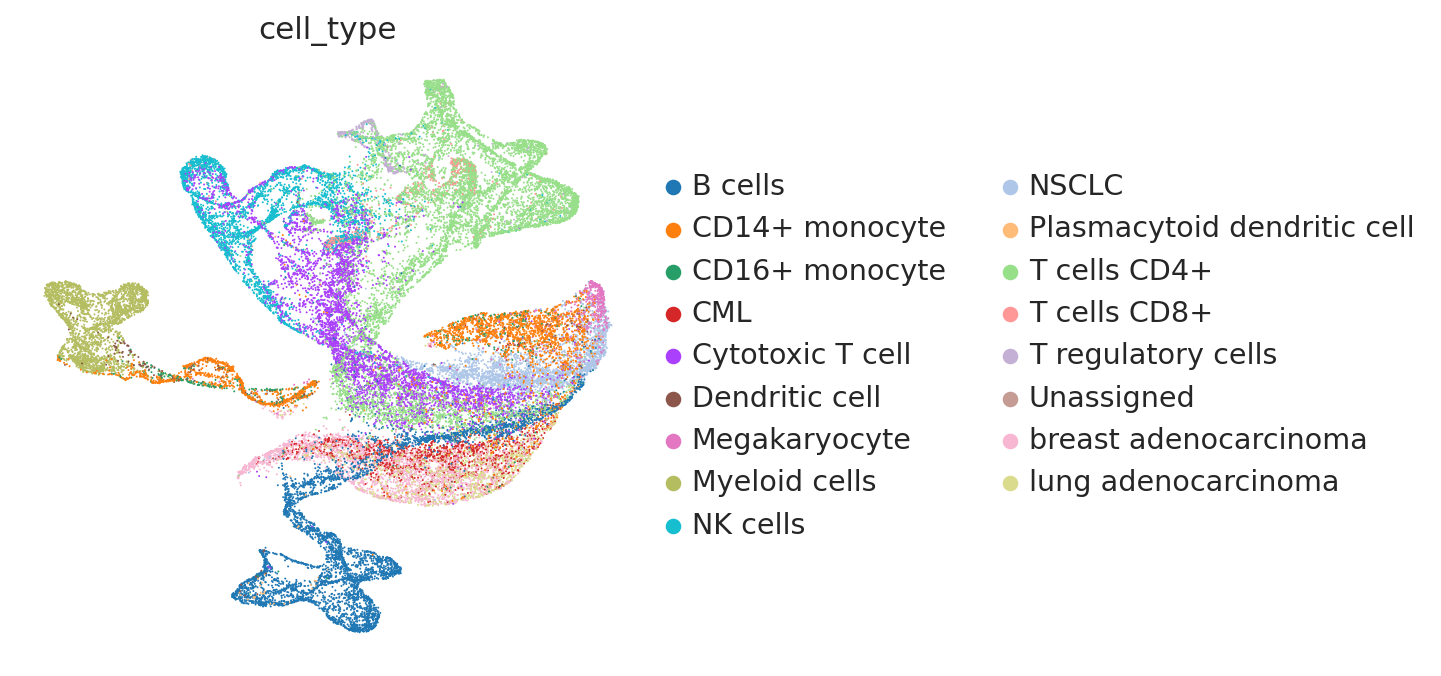

In [203]:
fig = sc.pl.umap(
    all_pred,
    color=["cell_type"],
    frameon=False,
    return_fig=True,
    show=False,
)
fig.savefig(f'{drug}_all_pred_umap.png',dpi=300,bbox_inches='tight')

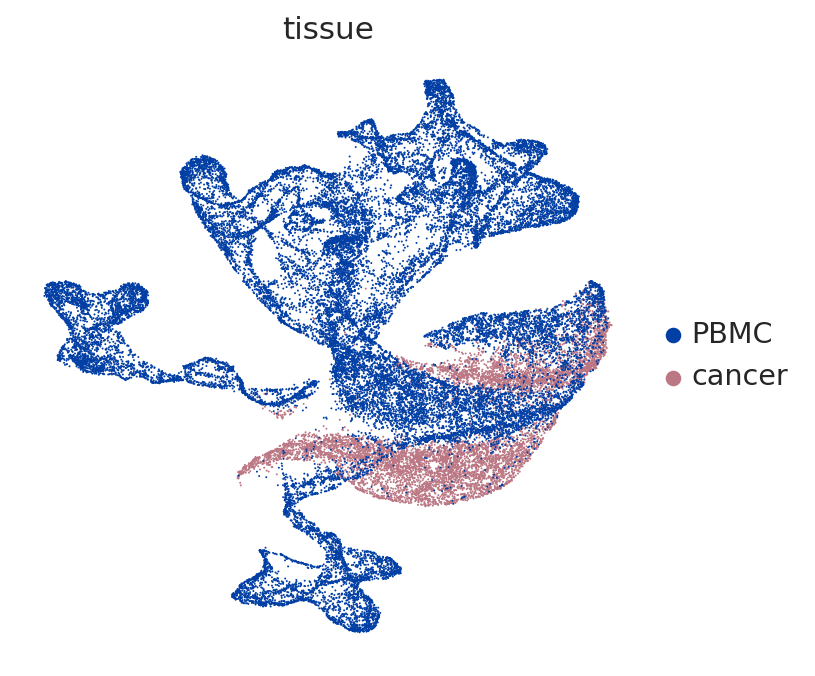

In [204]:
fig = sc.pl.umap(
    all_pred,
    color=["tissue"],
    frameon=False,
    return_fig=True,
    show=False,
    palette=['#023fa5','#bb7784'],
)
fig.savefig(f'{drug}_all_pred_tissue_umap.png',dpi=300,bbox_inches='tight')

In [184]:
del nips_lat.obs
del sci_lat.obs 
del pc9_lat.obs 
del bench_lat.obs 

In [198]:
all_lat = sc.concat([nips_lat,sci_lat,pc9_lat,bench_lat])
all_lat.obs = all_pred.obs.copy()

In [ ]:
sc.pp.neighbors(all_lat)
sc.tl.umap(all_lat, min_dist=0.3)

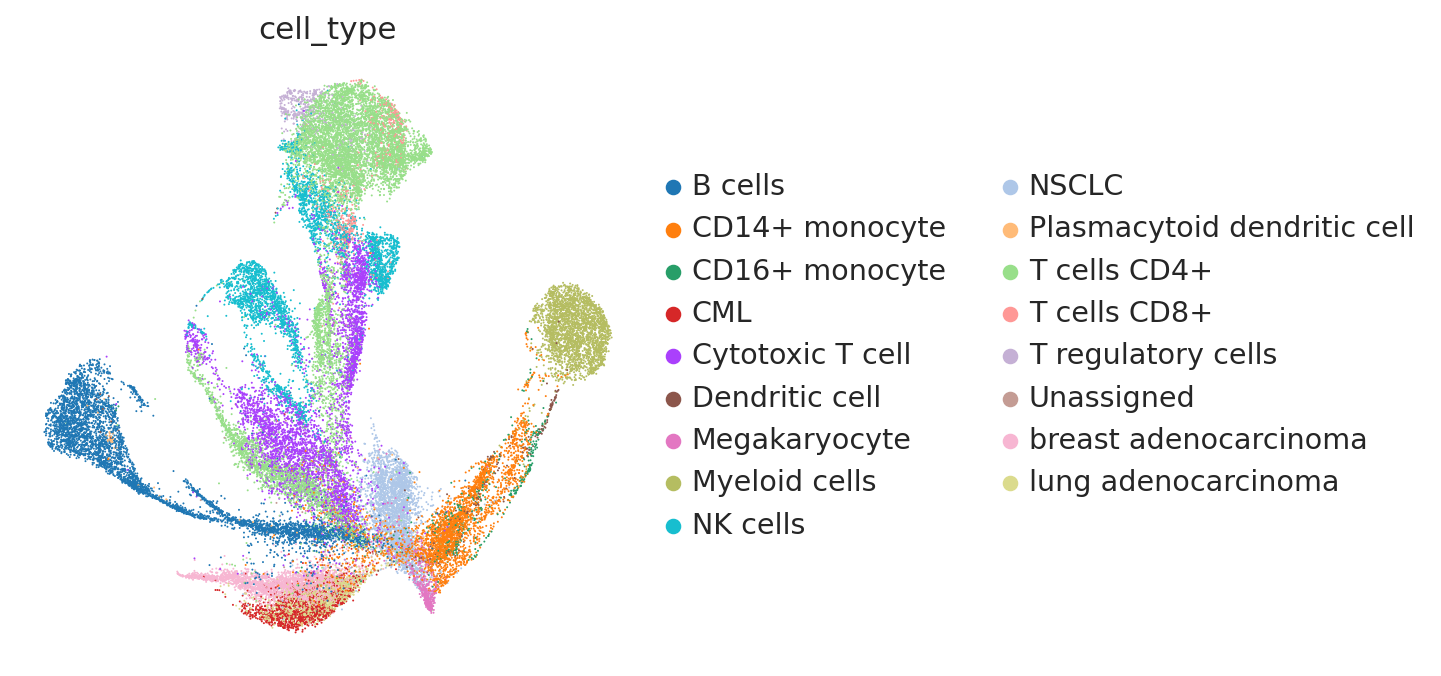

In [205]:
fig = sc.pl.umap(
    all_lat,
    color=["cell_type"],
    frameon=False,
    return_fig=True,
    show=False,
)

fig.savefig(f'{drug}_all_lat_umap.png',dpi=300,bbox_inches='tight')

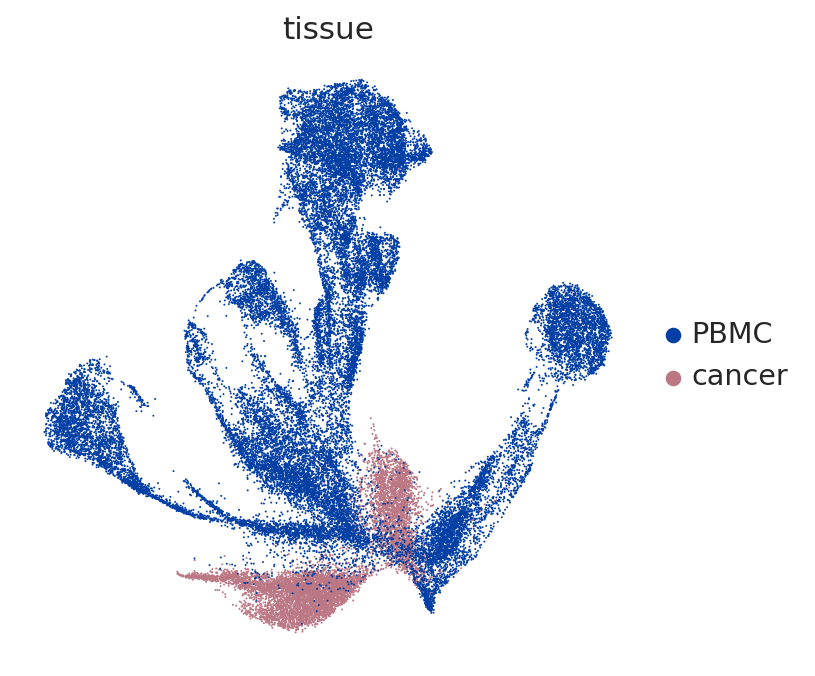

In [206]:
fig = sc.pl.umap(
    all_lat,
    color=["tissue"],
    frameon=False,
    return_fig=True,
    show=False,
    palette=['#023fa5','#bb7784']
)

fig.savefig(f'{drug}_all_lat_tissue_umap.png',dpi=300,bbox_inches='tight')